In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import pickle
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [2]:
G = nx.Graph()
list_nodes = []
with open('user_connections_largest_all.pickle', 'rb') as f:
    list_nodes = pickle.load(f)
df = pd.DataFrame(list_nodes)
print(df)
square_edges = pd.DataFrame(
    {"source": list(df['name']), "target": list(df['friend_id'])}
)
G = StellarGraph(edges=square_edges)
print("Number of nodes in a graph: ", len(G.nodes(
print("Number of edges in a graph: ", len(G.edges())))))

       friend_id       name
0            341      41188
1            535      41188
2           5408      41188
3           5948      41188
4           6998      41188
...          ...        ...
27519  565647440  254427002
27520  589493869  254427002
27521  594573653  254427002
27522  597831849  254427002
27523  609007855  254427002

[27524 rows x 2 columns]
Number of edges in a graph:  27524
Number of nodes in a graph:  27525


In [3]:
rw = BiasedRandomWalk(G)
listP = ['0.25', '0.5', '1', '2', '4']
listQ = ['0.25', '0.5', '1', '2', '4']

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)
model.save("word2vec_all.emb")

In [4]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = []
with open('more_infomation_user_data_all.pickle', 'rb') as f:
    list_data = pickle.load(f)
node_targets = list(map(lambda x: list_data[int(x)]['sex'] == 2, list(G.nodes())))

In [5]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

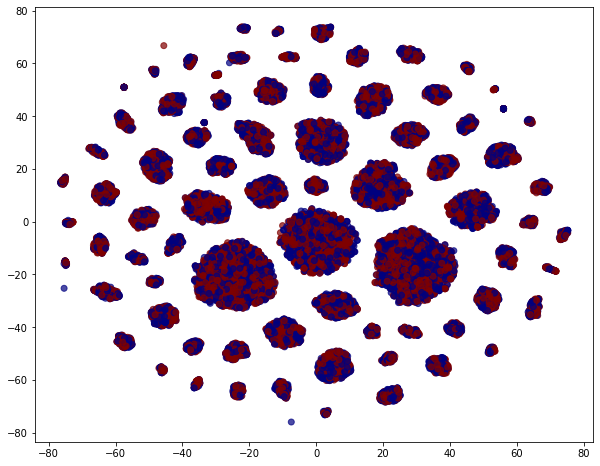

In [6]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [7]:
# X will hold the input features
X = node_embeddings
print(X)
# y holds the corresponding target values
y = np.array(node_targets)

[[ 0.12821145  0.02586343 -0.07407126 ... -0.43985105 -0.37039977
   0.00741956]
 [ 0.3918243  -0.08428633 -0.18402256 ... -0.5646923  -0.2086265
   0.31127685]
 [ 0.634222    0.40543392 -0.4549686  ... -0.00812502 -0.35599172
   0.37701967]
 ...
 [-0.01429506  0.3625685  -0.3982914  ... -0.35324797 -0.23437437
   0.1871579 ]
 [ 0.17943375  0.08861817 -0.14759657 ... -0.4017508  -0.30400375
  -0.02730793]
 [ 0.39652437  0.45078734 -0.38598537 ... -0.3984166  -0.0514182
  -0.16765761]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=None)

In [9]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (16515, 128)
 y_train = (16515,)
 X_test = (11010, 128)
 y_test = (11010,)


In [10]:
clf = LogisticRegressionCV(
    Cs=2, cv=2, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

LogisticRegressionCV(Cs=2, cv=2, max_iter=300, multi_class='ovr',
                     scoring='accuracy', verbose=False)

In [11]:
y_pred = clf.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred)

0.5143505903723887

In [13]:
with open('best_node2vec_model_all.pickle', 'wb') as f:
    pickle.dump(clf, f)